# Event Detection (& Association)
The first stage of the monitoring process is to detect anomalous events - short, transient signals of a few seconds to 1-2 minutes. The classic approach (since late 1970s?) has been to use a Short-Term Average (STA) to Long-Term Average (LTA) ratio-based Detector.

## Steps:
- Run an <b>STA/LTA Detector</b> on each channel of continuous waveform data (to each ObsPy Trace object wthin a Stream object).This yields a set of Trigger (or Detection) ON and OFF times.
- Run an <b>Associator</b> on the full set of Triggers. If multiple channels have Trigger ON status at the same time, record as an Event in a Catalog.

In ObsPy, both steps can be done using `coincidence_trigger` from the `obspy.signal.trigger` package.

## Examples:
1. Run an STA/LTA Detector on a single channel of data, on just 1 hour of data.
2. Run an STA/LTA Detector and Associator on multiple channels of data (a Stream object), on just 1 hour of data.
3. Run an STA/LTA Detection and Associator on multiple channels of data (a Stream object), for multiple days of data.

## Dataset
For this tutorial, we will use data from the Montserrat Volcano Observatory. On many occasions there was drumbeat seismicity in the days before a major dome collapse of the Soufriere Hills Volcano. We focus on the major dome collapse that occurred on July 12-13th, 2003.

The continuous waveform data will come from a "SeisComP Data Structure" (https://docs.obspy.org/packages/autogen/obspy.clients.filesystem.sds.html) or "SDS" archive. We will explore this first. We can create a client connection to as SDS archive using the Client class from the `obspy.clients.filesystem.sds` package.

In [1]:
# Import general packages
import os
import sys
from pathlib import Path
import obspy
import warnings
warnings.filterwarnings("ignore") # turn off warnings about Miniseed file encoding (and anything else!)

# Import local packages
sys.path.append('lib')
import vsmTools
import denoise

# Define where SDS archive and EVENTS data are stored
DATA_DIR = os.path.join('data')
SDS_DIR = os.path.join(DATA_DIR, 'continuous','SDS')
EVENTS_DIR = os.path.join(DATA_DIR, 'events')
CATALOG_DIR = os.path.join(DATA_DIR,'catalogs')

# Create a connection to an SDS archive
from obspy.clients.filesystem.sds import Client
sdsclient = Client(SDS_DIR)

# Show a tree listing of SDS_DIR
print('Tree listing of SDS_DIR directory')
for line in vsmTools.tree(Path(os.path.join(SDS_DIR, '2003'))):
    print(line)



Tree listing of SDS_DIR directory
├── .DS_Store
└── MV
    ├── MBLG
    │   ├── .DS_Store
    │   └── SHZ.D
    │       ├── MV.MBLG..SHZ.D.2003.194
    │       ├── MV.MBLG..SHZ.D.2003.193
    │       ├── MV.MBLG..SHZ.D.2003.192
    │       ├── MV.MBLG..SHZ.D.2003.195
    │       ├── MV.MBLG..SHZ.D.2003.190
    │       ├── MV.MBLG..SHZ.D.2003.197
    │       ├── MV.MBLG..SHZ.D.2003.196
    │       └── MV.MBLG..SHZ.D.2003.191
    ├── MBRY
    │   └── BHZ.D
    │       ├── MV.MBRY..BHZ.D.2003.195
    │       ├── MV.MBRY..BHZ.D.2003.192
    │       ├── MV.MBRY..BHZ.D.2003.193
    │       ├── MV.MBRY..BHZ.D.2003.194
    │       ├── MV.MBRY..BHZ.D.2003.191
    │       ├── MV.MBRY..BHZ.D.2003.196
    │       ├── MV.MBRY..BHZ.D.2003.197
    │       └── MV.MBRY..BHZ.D.2003.190
    ├── .DS_Store
    ├── MBWH
    │   ├── .DS_Store
    │   └── SHZ.D
    │       ├── MV.MBWH..SHZ.D.2003.192
    │       ├── MV.MBWH..SHZ.D.2003.195
    │       ├── MV.MBWH..SHZ.D.2003.194
    │       ├── MV.MBWH..SHZ.D

Let's look at a helicorder plot of a few hours of data. This will help us choose appropriate STA/LTA parameters

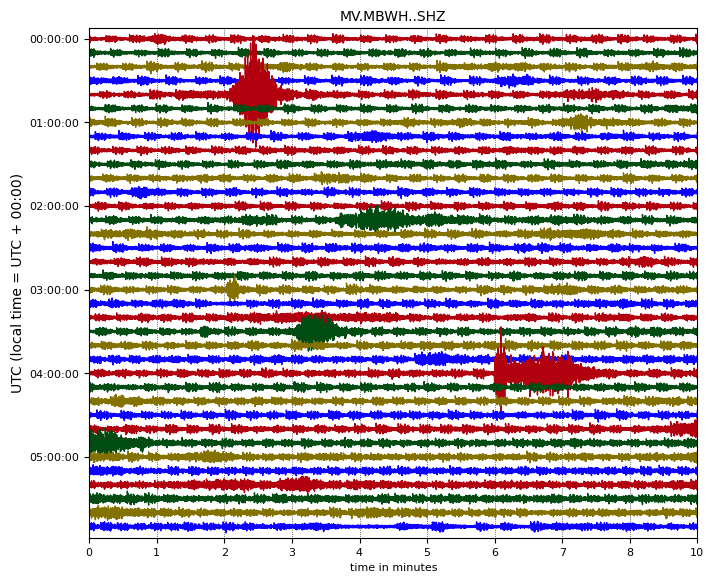

In [2]:
st = sdsclient.get_waveforms("MV", "MBWH", "", "SHZ", obspy.UTCDateTime(2003, 7, 11), obspy.UTCDateTime(2003, 7, 11, 6, 0, 0))
st.plot(type='dayplot', interval=10, vertical_scaling_range=3e3);

Looking above we can see there were up to 3 events per minute. 

Seismic and infrasound waves are essentially low-frequency sound waves in the ground and air respectively, so it makes sense to listen to them. ObsPy makes this easy to do:  

Let's try to denoise using "NoiseCut" by Zahra Zali

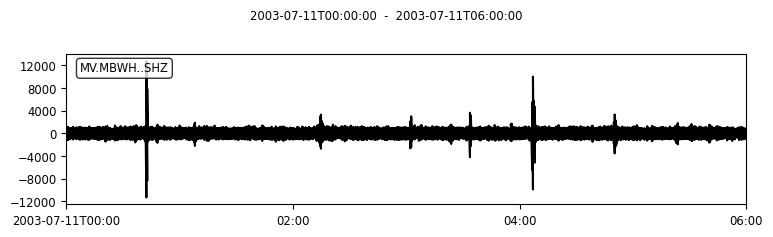

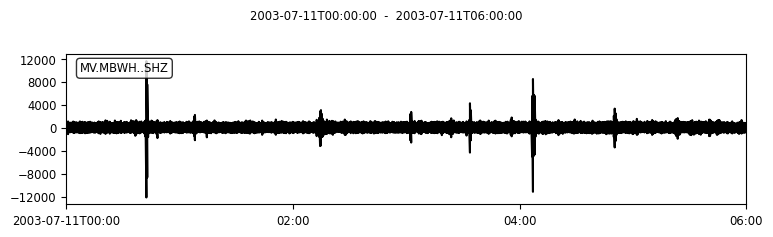

Processing original Trace
Running similarity filter
4096 219
Running median filter
4096 219
Running median filter on spectrogram from similarity filter
4096 219
Running similarity filter on spectrogram from median filter
4096 219


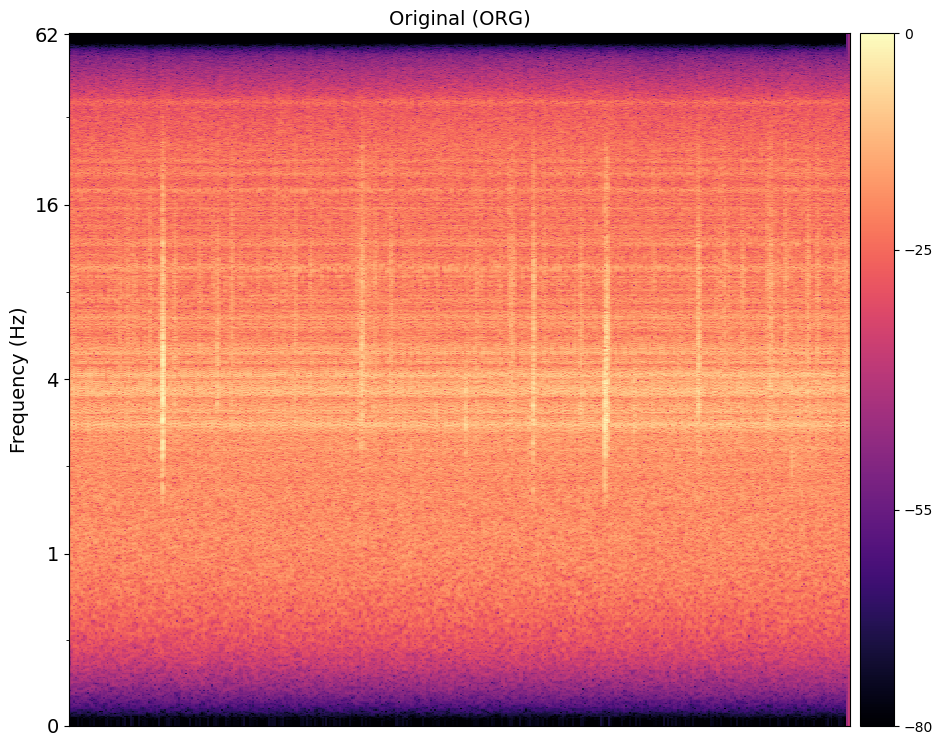

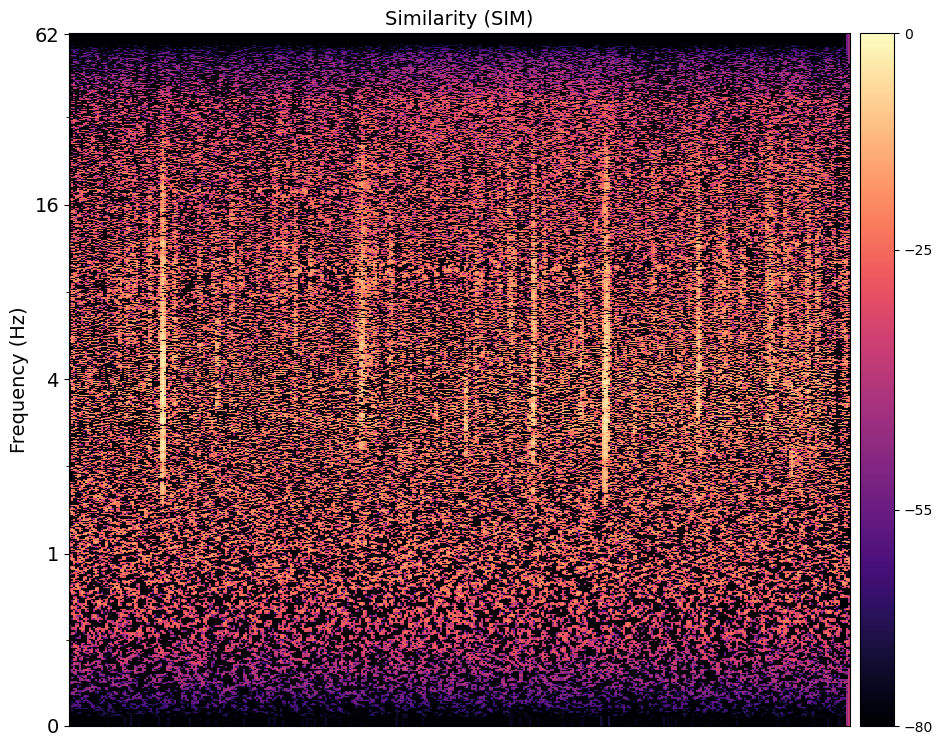

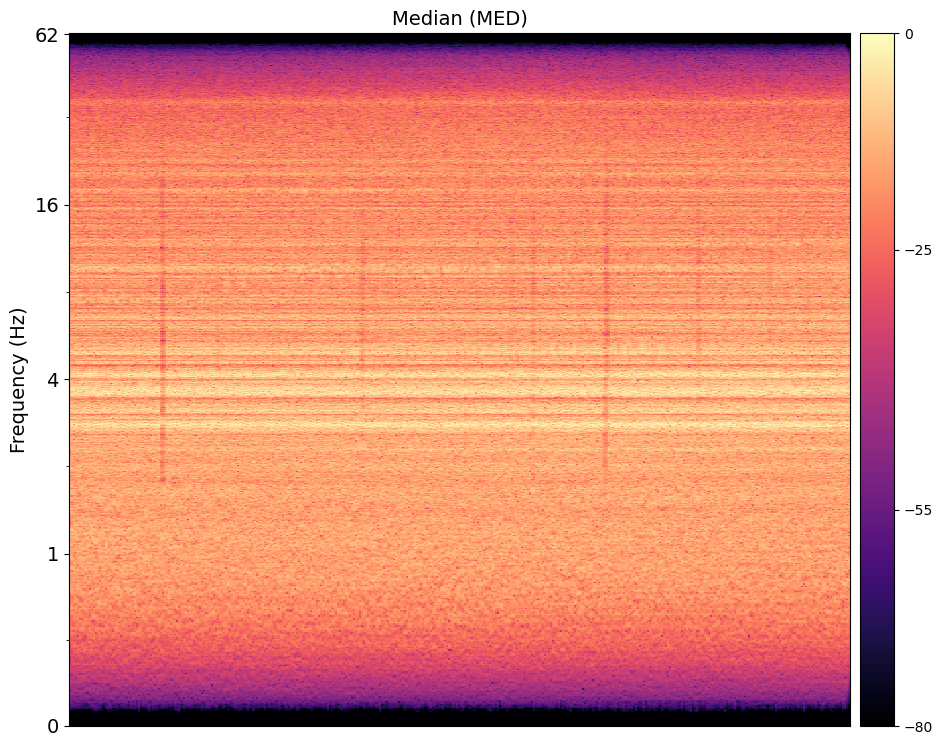

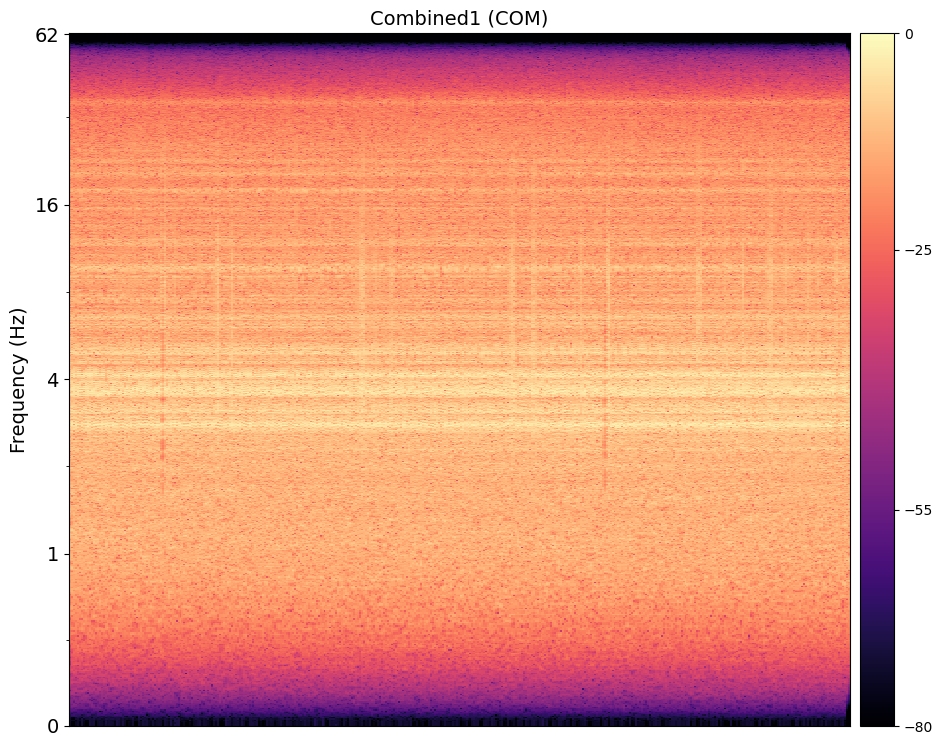

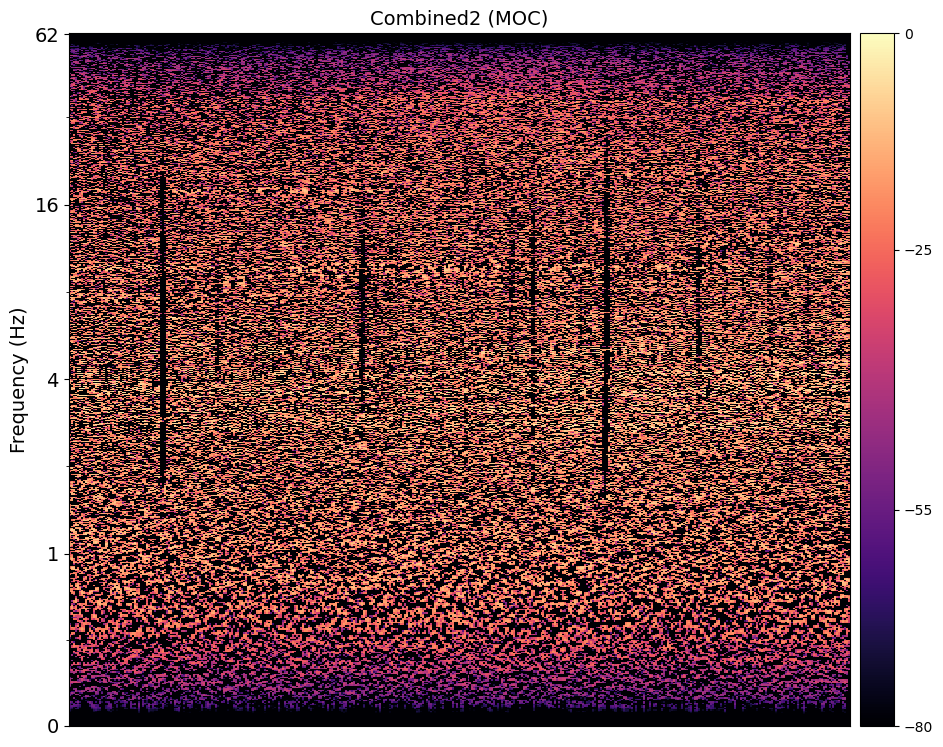

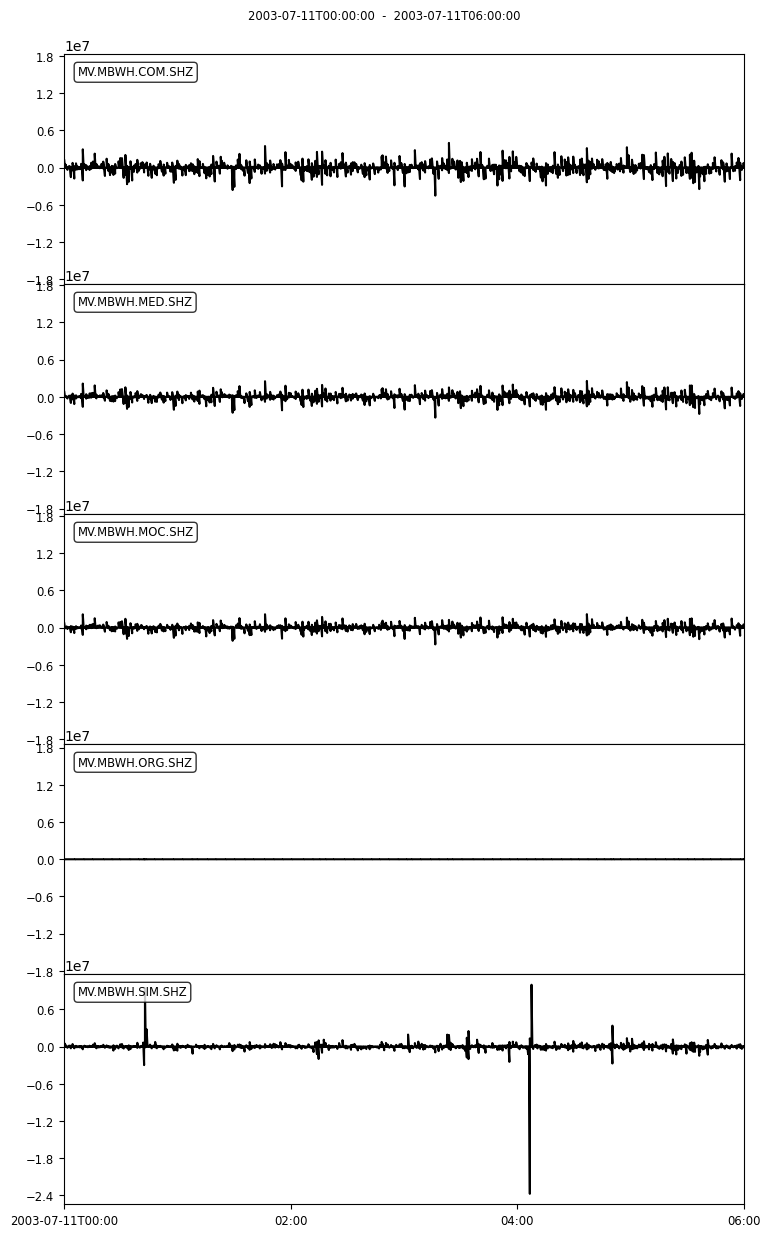

In [ ]:
duration = None
denoised_st = obspy.Stream()

for tr_in in st:

    if duration:
        tr_in.trim(starttime=tr_in.stats.starttime, endtime=tr_in.stats.starttime+duration)
    tr_in.plot();
        
    tr_filt = tr_in.copy()
    tr_filt.detrend('linear')
    tr_filt.filter('bandpass', freqmin=0.5, freqmax=18.0)
    tr_filt.plot();
    
    st_out = denoise.denoise(tr_filt, plot_spectrograms=True, plot_Stream=True)
    
    tr_out = st_out.select(location='COM')[0]
    denoised_st.append(tr_out.copy())

    #
    i = input('any key')

#denoised_st.plot(type='dayplot', interval=10, vertical_scaling_range=3e3);

In [ ]:
import math
import numpy as np
import librosa
from obspy import Trace
import librosa.display
import matplotlib.pyplot as plt



def _next_pow2(n):
    return int(round(2**np.ceil(np.log2(n))))


def _valid_win_length_samples(win_length_samples, win_length, sampling_rate):
    if win_length_samples is None and win_length is None:
        # fully automatic window length
        win_length_samples = _next_pow2(120*sampling_rate)

    elif win_length_samples is None and win_length is not None:
        win_length_samples = _next_pow2(win_length*sampling_rate)

    elif win_length_samples is not None and win_length is not None:
        raise ValueError(
            'Parameters win_length and win_length_samples are mutually '
            'exclusive.')
    elif win_length_samples is not None and win_length is None:
        # check win_length_samples is a power of 2
        win_length_samples = int(win_length_samples)
        if win_length_samples != _next_pow2(win_length_samples):
            raise ValueError(
                'Parameter win_length_samples must be a power of 2.')

    return win_length_samples


def noisecut(
        trace,
        ret_spectrograms=False,
        win_length_samples=None,
        win_length=None):
    '''
    Reduce noise from all the components of the OBS data using HPS noise
    reduction algorithms.

    :param win_length_samples:
        Window length in samples. Must be a power of 2. Alternatively it can be
        set with `win_length`.
    :type win_length_samples:
        int

    :param win_length:
        Window length [s]. Alternatively it can be set with
        `win_length_samples`.
    :type win_length:
        float

    :returns:
        The HPS trace and the spectrograms of the original, noise, and hps
        trace as well as an array with the frequencies.
    :return_type:
        tuple ``(hps_trace, (s_original, s_noise, s_hps, frequencies))``
    '''

    x = trace.data.astype(float)

    win_length_samples = _valid_win_length_samples(
        win_length_samples, win_length, trace.stats.sampling_rate)

    hop_length = win_length_samples // 4 #####
    n_fft = win_length_samples

    # Compute the spectrogram amplitude and phase
    S_full, phase = librosa.magphase(librosa.stft(
        x,
        n_fft=n_fft,
        hop_length=hop_length,
        win_length=win_length_samples)) # glenn could hardcode these values
    print(hop_length, win_length)

    l1 = math.floor((0.1 * win_length_samples) / trace.stats.sampling_rate)
    l2 = math.ceil((1 * win_length_samples) / trace.stats.sampling_rate)

    S_full1 = S_full # cheat glenn

    ''' glenn prpobably do not need
    # We consider the frequency range out of the [0.1-1] Hz for the first step # glenn might only need step 1
    S_full2 = np.zeros((S_full.shape[0], S_full.shape[1]))
    S_full2[l1:l2, :] = S_full[l1:l2, :]

    # We consider the frequency range of [0.1-1] Hz for the second step # SIM simulation matrix
    S_full1 = np.zeros((S_full.shape[0], S_full.shape[1]))
    S_full1[:l1, :] = S_full[:l1, :]
    S_full1[l2:, :] = S_full[l2:, :]
    '''

    # We'll compare frames using cosine similarity, and aggregate similar
    # frames by taking their (per-frequency) median value.
    widthval = np.min([(S_full1.shape[-1] - 1) // 2, 200]) - 1
    print("WIDTHVAL: ",widthval) ## can just use 1 for widthval
    widthval=1 # added by glenn
    S_filter = librosa.decompose.nn_filter(
        S_full1,
        aggregate=np.median,
        metric='cosine', width=widthval) 

    # The output of the filter shouldn't be greater than the input
    S_filter = np.minimum(np.abs(S_full1), np.abs(S_filter))
    margin_i = 1
    power = 2

    # Once we have the masks, simply multiply them with the input spectrogram
    # to separate the components.
    mask_i = librosa.util.softmask(
        S_filter,
        margin_i * (S_full1 - S_filter),
        power=power)

    S_background = mask_i * S_full1
    ''' glenn do not need second step
    # In the second step we apply a median filter 
    D_harmonic, D_percussive = librosa.decompose.hpss(
        S_full2,
        kernel_size=80, # was 40, longer will capture more noise but might cut amplitude of earthquake, try 40
        margin=5)

    S_background = S_background + D_harmonic
    '''

    f = S_background * phase
    L = x.shape[0]
    new = librosa.istft(
        f,
        hop_length=hop_length,
        win_length=win_length_samples,
        window='hann',
        length=L)
    
    z = x - new
    stats = trace.stats
    stats.location = 'NC'

    hps_trace = Trace(data=z, header=stats)
    hps_trace.write( 'NoiseCut.mseed', format='MSEED', encoding=5, reclen=4096)

    if ret_spectrograms:

        S_hps = S_full - S_background
        df = trace.stats.sampling_rate/win_length_samples
        frequencies = np.arange(S_hps.shape[0]) * df
        times = np.arange(S_hps.shape[1]) * hop_length

        return hps_trace, (S_full, S_background, S_hps, frequencies, times)
    else:
        return hps_trace



def plot_noisecut_spectrograms(S_full, S_background, S_hps, frequencies, times, fig=None):
    
    show = False
    if fig is None:
        fig= plt.figure(figsize=(15, 9))

        axs=fig.add_subplot(311)
        pcm=axs.pcolormesh(times, frequencies, librosa.power_to_db(np.abs(S_full)), cmap = 'magma', shading= 'auto')
        #plt.ylim(0,1)
        plt.title('Full spectrogram', fontsize=14)
        plt.ylabel('Frequency (Hz)', fontsize=14)
        plt.yticks (fontsize= 14)
        axs.set_xticks([])
        cbar=fig.colorbar(pcm, ax=axs, pad= 0.01)
        cbar.ax.tick_params(labelsize=14) 
    
        axs=fig.add_subplot(312)
        pcm=axs.pcolormesh(times, frequencies, librosa.power_to_db(np.abs(S_background)), cmap = 'magma', shading= 'auto')
        #plt.ylim(0,1)
        plt.title('Noise spectrogram', fontsize=14)
        plt.ylabel('Frequency (Hz)', fontsize=14)
        plt.yticks (fontsize= 14)
        axs.set_xticks([])
        cbar=fig.colorbar(pcm, ax=axs, pad= 0.01)
        cbar.ax.tick_params(labelsize=14)
    
        axs=fig.add_subplot(313)
        pcm=axs.pcolormesh(times, frequencies, librosa.power_to_db(np.abs(S_hps)), cmap = 'magma', shading= 'auto')
        #plt.ylim(0,1)
        plt.title('Denoised spectrogram', fontsize=14)
        plt.ylabel('Frequency (Hz)', fontsize=14)
        plt.yticks (fontsize= 14)
        cbar=fig.colorbar(pcm, ax=axs, pad= 0.01)
        cbar.ax.tick_params(labelsize=14) 
        labelsx = [0,4,8,12,16,20,24]
        plt.xticks(np.arange(0,times[-1],(times[-1]/6)-1), labelsx, fontsize= 14)
        
        plt.tight_layout()
        #fig.savefig ('NoiseCut spectrograms.png', dpi=100)
        #plt.close(fig)
        fig.show()

In [ ]:
st = obspy.read('../../NoiseCut/examples/D10.DO.HH4..D.2012.080.000000')
hps_trace, spectrograms = noisecut(st[0], ret_spectrograms=True)
plot_noisecut_spectrograms(*spectrograms)

In [ ]:
st = sdsclient.get_waveforms("MV", "MBLG", "", "SHZ", obspy.UTCDateTime(2003, 7, 9, 7, 0, 0), obspy.UTCDateTime(2003, 7, 9, 7, 35, 0))
st.plot();
hps_trace, spectrograms = noisecut(st[0], ret_spectrograms=True)
#plot_noisecut_spectrograms(*spectrograms)

#st = obspy.read('../../NoiseCut/examples/D10.DO.HH4..D.2012.080.000000')

In [ ]:
st[-1].spectrogram()

In [ ]:

st = sdsclient.get_waveforms("MV", "MBWH", "", "SHZ", obspy.UTCDateTime(2003, 7, 11), obspy.UTCDateTime(2003, 7, 11, 1, 0, 0))
st.plot(type='dayplot', interval=10, vertical_scaling_range=3e3);
hps_trace, spectrograms = noisecut(st[0], ret_spectrograms=True)
plot_noisecut_spectrograms(*spectrograms)
hps_trace.spectrogram()

In [ ]:
fig= plt.figure(figsize=(15, 9))
axs=fig.add_subplot(312)
librosa.display.specshow(librosa.power_to_db(np.abs(hps_trace)), cmap = 'magma', shading= 'auto')

In [ ]:
wav_audio_file = os.path.join(DATA_DIR, 'MV20030711.wav')
st[0].write(wav_audio_file, rescale=True, format='WAV', framerate=6000*2)
os.system(f'open {wav_audio_file}') # works on Ubuntu Linux 22.04

This is called 'drumbeat seismicity'! 

## Example 1: Detect anomalous signals in 1 hour of data

First we load one hour of data from the SDS archive (multiple channels):

In [ ]:
# Set start time as "YYYYJJJT" where JJJ = (Julian calendar) day of year
stime = obspy.UTCDateTime("2003193T")
print(stime)
seconds = 3600

# Get and plot data
st = sdsclient.get_waveforms("MV", "*", "*", "?HZ", stime, stime+seconds)
st.plot(equal_scale=False);

Run STA/LTA Detector on the final Trace object (MV.MBWH..SHZ) in the Stream. We can use index = -1.

In [ ]:
# Detection
import numpy as np
from obspy.signal.trigger import plot_trigger, classic_sta_lta

st2 = st.copy()

tr_index = -1

Fs = int(np.round(st[tr_index].stats.sampling_rate, 0))
print(f"sampling_rate={Fs}")

corners = 3
sta_secs = 2.3
lta_secs = 11.5
threshON = 2.4
threshOFF = 1.2
freqmin = 1.5
freqmax = 12.0    

st2.filter('bandpass', freqmin=freqmin, freqmax=freqmax, corners=corners)
sta_samples = int(sta_secs * Fs)
lta_samples = int(lta_secs * Fs)

#cft = recursive_sta_lta(st2[tr_index].data, sta_samples, lta_samples )
#threshOFF = 1.2
cft = classic_sta_lta(st2[tr_index].data, sta_samples, lta_samples )

plot_trigger(st2[tr_index], cft, threshON, threshOFF)

The top plot shows Trigger ON (red lines) and Trigger OFF (blue lines) times. The bottom line shows the STA:LTA ratio, where "Trigger ON" (red) corresponds to 2.4, and "Trigger OFF" corresponds to 0.5).

## Example 2: Run STA/LTA on all (good) channels
Next we run `coincidence_trigger` on the whole Stream object, choosing the same 'Classic STA/LTA" method as before, and the same input parameters. Since we have 6 'good' channels (Trace objects), we will require at least 3 stations to trigger ON at the same time before a network trigger is declared.

In [ ]:
from obspy.signal.trigger import coincidence_trigger
from pprint import pprint

threshStations = 3 # minimum number of channels that must reach trigger ON at the same time before a network trigger is declared.
max_secs = 120.0 # no trigger will remain on for longer than 2 minutes

staltamethod = 'classicstalta'
trig = coincidence_trigger(staltamethod, threshON , threshOFF, st2, threshStations, sta=sta_secs, lta=lta_secs, max_trigger_length=max_secs, details=True)

for i, this_trig in enumerate(trig):
    print('\n',f'Event {i}')
    pprint(this_trig)

93 network triggers were declared within that one hour time window. 

The trig variable is a list of dictionaries. Each dictionary describes a single network trigger, and contains fields including 'time' which has the UTCDateTime at which the network trigger began, 'coincidence_sum' stores the number of channels that simultaenously triggered, and 'trace_ids' tells us the specific channels that triggered. 

We will assume that each trigger a volcano-seismic event, i.e. a transient (short-lived) anomalous signal. ObsPy includes classes (object-oriented blueprints of new data types useful for Seismology) for storing each `Event` within a `Catalog`. The structure of an ObsPy `Event` object is based on the QuakeML format, and though this isn't great match for volcano-seismic events, we will create an `Event` object for each network trigger. However, rather than use an ObsPy `Catalog` object directly, we have created a new class `VolcanoSeismicCatalog` which inherits `Catalog` and expands on it. This should all be invisible to you - it happens in the `tools` package, imported above. All we have to do is call `tools.triggers2catalog` and it returns a `VolcanoSeismicCatalog` object.

It will also segment out a window of data for each Event beginning pretrig seconds before the trigger ON time and ending posttrig seconds after the trigger OFF time.

In [ ]:
import pandas as pd
pretrig = 10 #lta_secs * 2
posttrig = 20 # lta_secs * 2   
catalogObj = vsmTools.triggers2catalog(trig, staltamethod, threshON, threshOFF, \
                                        sta_secs, lta_secs, max_secs, stream=st2, pretrig=pretrig, posttrig=posttrig )
    
print(catalogObj)

By expanding on the ObsPy `Catalog` class, we have added several new methods, some of which we will use. For example, we can make plots of event rate and energy release rate:

In [ ]:
catalogObj.plot_eventrate(binsize=pd.Timedelta(minutes=1))

So we have the basic ability to detect events. Unlike the examples in the presentation which are chosen for clarity and having an excellent signal to noise ratio, the events shown in the plots above are not really obvious at all. This is quite typical. Indeed, in this case we are trying to detect events amongst a background of heightened unrest - earthquake swarms that became drumbeat-like and merge into a continuous tremor. It is important to note that STA/LTA algorithms often break down when volcano-seismicity is at its highest!

Anyway, let us now try to run this on several days on data and see how many events we can detect.

## Example 3: Run coincidence trigger on multiple days, and concatenate catalogs for each day into one

(This takes about 1 minute to run on my office Linux PC)

In [ ]:
# set parameters
threshStations = 3 # minimum number of stations that must trigger for a coincidence trigger to occur
max_secs = 120.0
staltamethod = 'classicstalta' 
corners = 3
sta_secs = 2.3
lta_secs = 11.5
threshON = 2.4
threshOFF = 1.2
freqmin = 1.5
freqmax = 12.0  
catalog_all = None

for jday in range(190, 197, 1): # Loop over days in SDS archive
    for hour in range(24):
        # set start time & show counting through days and hours
        stime = obspy.UTCDateTime(f"2003{jday}T") + hour * 3600
        if hour==0:
            print(stime.strftime('%Y/%m/%d %H'), end=' ')
        elif hour==23:
            print(stime.hour)
        else:
            print(stime.hour, end=' ')
    
        # Get and plot data
        st = sdsclient.get_waveforms("MV", "*", "*", "?HZ", stime, stime+3600)
        if len(st)==0:
            continue
    
        # remove bad channels, including those with insufficient samples
        for tr in st:
            if tr.stats.npts < max_secs * tr.stats.sampling_rate:
                st.remove(tr)

        if len(st)==0:
            continue
    
        # bandpass filter
        st.filter('bandpass', freqmin=freqmin, freqmax=freqmax, corners=corners)
    
        # run coincidence trigger for this day
        trig = coincidence_trigger(staltamethod, threshON , threshOFF, st, threshStations, sta=sta_secs, lta=lta_secs, max_trigger_length=max_secs, details=True)
        if len(trig)==0:
            continue

        # create catalog object
        catalogObj = vsmTools.triggers2catalog(trig, staltamethod, threshON, threshOFF, \
                                                      sta_secs, lta_secs, max_secs, stream=st, pretrig=pretrig, posttrig=posttrig )
    
        # save the event streams to miniseed, and then erase them to free up memory
        catalogObj.write_events(outdir=EVENTS_DIR)
        catalogObj.streams = []
    
        # concatenate catalogs
        if catalog_all:
            catalog_all.concat(catalogObj)
        else:
            catalog_all = catalogObj

If we print this 1-week-long catalog, we see it has ~4300 events. Over 600 events per day on average!

In [ ]:
print(catalog_all)

Since the events are not located, the latitude, longitude, and depth are set to None.

The magnitude (column that starts with 0.44) is not calibrated and is based on the log10(peak_amplitude) of each Trace. Since the Traces are raw (not instrument corrected), the peak amplitude is in Counts. A bit more on this below.

We can print a single event too:

In [ ]:
print(catalog_all.events[0])

And view the amplitude information that came from the coincidence trigger: 

In [ ]:
for a in catalog_all.events[0].amplitudes: # a is an ObsPy Amplitude object
    print(f"id={a['waveform_id'].id}, amp={a['generic_amplitude']:.1f}, snr={a['snr']:.2f}")

We also have a very first-order magnitude, which is uncalibrated (we'll improve on this soon), but somewhat useful as a real-time relative size indicator. It is computed as the base-10 logarithm of the median amplitude of an event across the set of triggered stations:

In [ ]:
for sm in catalog_all.events[0].station_magnitudes: # a is an ObsPy Amplitude object
    print(f"id={sm['waveform_id'].id}, mag={sm['mag']:.1f}")
for m in catalog_all.events[0].magnitudes: # a is an ObsPy Amplitude object
    print(f"magnitude={m['mag']:.1f}")

### Convert catalog object to a pandas DataFrame
While it is great to make use of the ObsPy Catalog class(which we inherited and expanded into a VolcanoSeismicCatalog class), so we can leverage its methods like exporting to QuakeML, it is also much easier to work with a pandas dataframe.

Anyone not familiar with pandas dataframes? They are like Excel spreadsheets (and can be imported from and exported to Excel spreadsheets or CSV files), but are far more powerful!

Anyway, we convert a VolcanoSeismicCatalog object to a dataframe like this:

In [ ]:
catDF = catalog_all.to_dataframe()

And we can view it like any other pandas dataframe:

In [ ]:
print(catDF)

As you can see, so far we have no latitude/longitude/depth coordinates, and no classifications. The energy column here is based on the magnitude - and we'll improve on this in later notebooks.

And pandas dataframes with a datetime index/column are easy to plot, for example:

In [ ]:
catDF.plot.scatter(x='datetime', y='duration', s=0.1, rot=90, xlabel='Date', ylabel='Trigger duration (s)')

Recall that 120s was our max trigger length. A few of the events early on are 120s long. But the bulk of the events are much shorter. Indeed, we can change the y-limits and see: 

In [ ]:
ax = catDF.plot.scatter(x='datetime', y='duration', s=0.1, rot=90, xlabel='Date', ylabel='Trigger duration (s)')
ax.set_ylim([0,20])

This means we did a good job of capturing short transient events, but missed longer signals. This is a common trade-off with STA/LTA methods.

In [ ]:
ax = catDF.plot.scatter(x='datetime', y='magnitude', s=0.1, rot=90, xlabel='Date', ylabel='Uncalibrated Magnitude')
ax.set_ylim([0, 3])

We can observe that the magnitude of the detected events increases significantly from about 2003/07/12 08:00 until about 2003/07/13 02:00. Let's see what is happening in the raw data: 

In [ ]:
st2 = sdsclient.get_waveforms("MV", "MBWH", "", "SHZ", obspy.UTCDateTime(2003, 7, 12, 8, 0, 0), obspy.UTCDateTime(2003, 7, 13, 2, 0, 0))
st2.plot(type='dayplot', interval=10, vertical_scaling_range=8e3);

We observe that the background level of seismicity is increasing. This is a progressive dome collapse that began with intense rainfall leading to lahars and individual pyroclastic flows that eventually become near-continuous and larger until most of the dome is gone. such rainfall-triggered dome collapses were common in Montserrat, and this underlines the importance of real-time rain gauge data. However, this was very much a dome that was ready collapse, since drumbeat seismicity usually resulted in dome collapses after 2-3 days. What isn't clear from this plot is whether the drumbeats merged into tremor as the drumbeats become drowned out by tremor-like lahar signals and much larger pyroclastic flow signals.

Let's save the whole catalog so we can load it in later notebooks. This creates an QuakeML (extension ".xml") file of the whole catalog, plus a Pickle file (extension ".pkl") containing variables that QuakeML cannot handle:

In [ ]:
catalog_all.save(CATALOG_DIR,'catalog_MV_20030712')
os.listdir(CATALOG_DIR)

Finally for the tutorial, we will visualize the catalog, using a binsize of 1 hour, and then 10 minutes. Pandas dataframes are easy to resample!

In [ ]:
import pandas as pd
catalog_all.plot_eventrate(binsize=pd.Timedelta(hours=1))

In [ ]:
catalog_all.plot_eventrate(binsize=pd.Timedelta(minutes=10))

The 10-minute binsize plot gives us a better indication of the rapid drop in detected event counts. We can zoom in on this with:

In [ ]:
import datetime
time_limits = [datetime.datetime(2003, 7, 12, 0, 0, 0), datetime.datetime(2003, 7, 14, 12, 0, 0)]
axs = catalog_all.plot_eventrate(binsize=pd.Timedelta(minutes=10), time_limits=time_limits)

How would you interpret the drop in event rate if you didn't have the magnitude or energy release rate plot too? Probably as a drop in overall seismicity!

### Observations:
- Most of the detected events occur in a 56-hour period from 2003/07/10 00:00, peaking around 120 events per hour.
- There is an abrupt drop in triggered event rate beginning at 2003/07/12 08:00
- The magnitude of events rises sharply from about 2003/07/12 12:00 through to 2003/07/13 02:00. Only the largest events trigger because of the high background "tremor" from lahars and pyroclastic flows.
- The energy release rate (from cumulative magnitude) peaks around the start of 2003/07/13 for about 4 hours.

### Key points:
- <b>Catalogs are flawed. They often show no seismicity when seismicity and hazards are peaking!</b>
- <b>Event rate and Energy release rates give us different information!</b>

